## <a name="abstract">Titanic Machine Learning From Disaster</a>

Abstract The sinking of the RMS Titanic is one of the most infamous shipwrecks in history. On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.
One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.
In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

In [1]:
using DataFrames
using DecisionTree
using Iterators
using GLM
using MLBase
using Gadfly

  likely near /Users/diego/.julia/v0.4/MLBase/src/modeltune.jl:5
  likely near /Users/diego/.julia/v0.4/MLBase/src/modeltune.jl:5
  likely near /Users/diego/.julia/v0.4/MLBase/src/modeltune.jl:5
  likely near /Users/diego/.julia/v0.4/MLBase/src/deprecated/datapre.jl:104
  likely near /Users/diego/.julia/v0.4/MLBase/src/deprecated/datapre.jl:105
  likely near /Users/diego/.julia/v0.4/MLBase/src/deprecated/datapre.jl:163
  likely near /Users/diego/.julia/v0.4/MLBase/src/deprecated/datapre.jl:163
  likely near /Users/diego/.julia/v0.4/MLBase/src/deprecated/datapre.jl:163


## Load Preprocessed Data

In [277]:
train = readtable("./data/train_enriched.tsv", separator='\t')
test = readtable("./data/test_enriched.tsv", separator='\t');

In [3]:
features = [:Pclass, :Sex, :Age, :SibSp, :Parch, :Fare, :Embarked,
            :Title, :FamilySize, :IsMother, :IsChild, :IsSmallFamily,
            :CabinPrefix, :CabinNumber]
label = :Survived;

In [84]:
function random_train_validation_sets(train, split_train_percentage)
    nrows = size(train, 1)
    indexes = shuffle(vcat(1:nrows))
    splitted_index_value = int(nrows*split_train_percentage)
    new_train = train[indexes[1:splitted_index_value], :]
    validation = train[indexes[splitted_index_value+1:end], :]
    return new_train, validation
end

binarize{T <: Number}(y::Array{T,1}) = Array{Int8,1}(y .>= .5)
binarize{T <: Integer}(y::T) = y >= .5? 1 : 0
function calc_accuracy{T <: Integer}(y_real::Array{T,1}, y_pred::Array{T,1})
    nrows = length(y_real)
    preds_diff = map(i -> y_real[i] == binarize(y_pred[i])?1:0, vcat(1:nrows))
    return round(sum(preds_diff)/nrows, 2)  
end
function calc_accuracy{T <: Integer}(y_real::Array{T,1}, y_preds::Array{Array{T,1},1})
    return map(y_pred -> calc_accuracy(Array{Int8}(y_real), Array{Int8}(y_pred)), y_preds)
end

calc_accuracy (generic function with 2 methods)

## Train Classifiers

### Logistic Regression

In [23]:
formulas = map(x -> parse(string(label, "~", join(x, "+"))), collect(subsets(features)))[2:end]

function gen_lms(formulas, train)
    lms = []
    accepted_formulas = []
    for formula in formulas
        try
            push!(lms, glm(eval(formula), train, Binomial()))
            push!(accepted_formulas, formula)
        catch LoadError
            continue
        end
    end
    return (accepted_formulas, lms)
end
    
predict_lms(lms, data) = Array{Array{Int8,1},1}(map(lm -> binarize(array(predict(lm, data))), lms))

predict_lms (generic function with 1 method)

In [94]:
repeat = 1
accepted_formulas_all = []
lms_all = []
accs_all = []
for r = 1:repeat
    training, validation = random_train_validation_sets(train, .90)
    accepted_formulas, lms = gen_lms(formulas, train)
    validation_predictions = predict_lms(lms, validation)
    accs = calc_accuracy(Array{Int8,1}(validation[label]), validation_predictions)
    append!(accepted_formulas_all, accepted_formulas)
    append!(lms_all, lms)
    append!(accs_all, accs)
end
accs = reshape(accs_all, (int(length(accs_all)/repeat), repeat))
accs_means = map(row -> mean(accs[row,:]), vcat(1:size(accs, 1)));

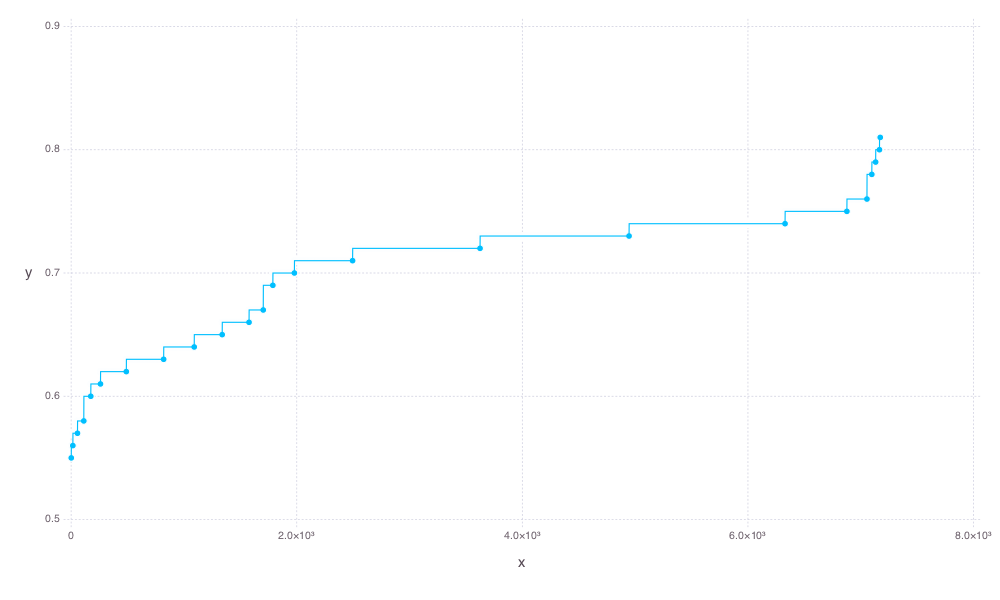

In [95]:
set_default_plot_size(1000px, 600px)
accs_above_threshold = filter(acc -> acc >= .5, accs_means)
plot(x=vcat(1:length(accs_above_threshold)), y=sort(accs_above_threshold), Geom.line, Geom.point)

In [159]:
df = DataFrame(formula=accepted_formulas_all, lm=lms_all, acc=accs_all)
df = df[df[:acc] .>= .75, :]
lms_selected = df[:lm]
training_predictions = predict_lms(lms_selected, train)
training_accs = calc_accuracy(Array{Int8,1}(train[label]), training_predictions);

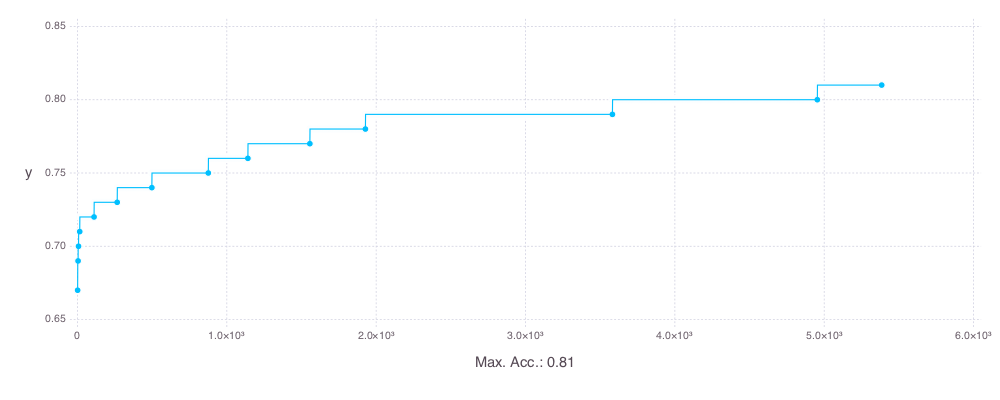

In [112]:
set_default_plot_size(1000px, 400px)
accs_above_threshold = filter(acc -> acc >= .5, training_accs)

plot(x=vcat(1:length(accs_above_threshold)), y=sort(accs_above_threshold), 
     Geom.line, Geom.point, Guide.xlabel("Max. Acc.: $(maximum(accs_above_threshold))"))

In [160]:
function correlation_matrix(predictions)
    nrows = size(predictions, 1)
    x = []; y = []; z = []
    for i=1:nrows, j=1:nrows
        push!(x, i)
        push!(y, j)
        push!(z, cor(predictions[i], predictions[j]))
    end
    return DataFrame(i=x, j=y, cor=z)
end
cor_df = correlation_matrix(training_predictions);

In [168]:
# plot(cor_df, x="i", y="j", color="cor", Scale.x_discrete, Scale.y_discrete, Geom.rectbin)

In [327]:
get_indexes(cor_df) = collect(Set(vcat(cor_df[:i], cor_df[:j])))
function predictions_to_matrix(predictions)
    nrows = length(predictions[1])
    ncols = length(predictions)
    return reshape(vcat(predictions...), (nrows, ncols))
end
function average_predictions(predictions_matrix)
    final_predictions = []
    ncols = size(predictions_matrix, 2)
    for row = 1:size(predictions_matrix, 1)
        push!(final_predictions, sum(predictions_matrix[row, :])/ncols >= .5? 1 : 0)
    end
    return Array{Int8,1}(final_predictions)
end

average_predictions (generic function with 1 method)

In [328]:
predictions_indexes_selected = get_indexes(cor_df[cor_df[:cor] .>= .5, :])
predictions_selected = training_predictions[predictions_indexes_selected]
predictions_matrix_selected = predictions_to_matrix(predictions_selected)
final_predictions = average_predictions(predictions_matrix_selected)
calc_accuracy(Array{Int8,1}(train[label]), final_predictions)

0.82

In [330]:
test_predictions = predict_lms(lms_selected[predictions_indexes_selected], test)
test_predictions_matrix = predictions_to_matrix(test_predictions)
final_test_predictions = average_predictions(test_predictions_matrix)
test_predictions_df = DataFrame(PassengerId=test[:PassengerId], Survived=final_test_predictions);

In [331]:
writetable("./data/prediction_v7_ensemble_learning_glm_cor.5.csv", test_predictions_df) # 0.76077